In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import torch 
from torch import nn
from torch.autograd import Variable

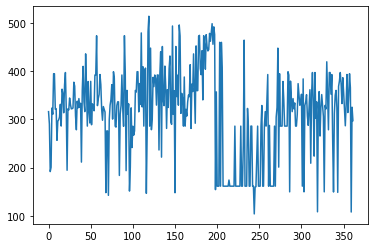

In [2]:
#LSTM（Long Short-Term Memory）是长短期记忆网络
data_csv = pd.read_csv('BS1_daily_data_2019.csv',usecols=[7])
#pandas.read_csv可以读取CSV（逗号分割）文件、文本类型的文件text、log类型到DataFrame
#原有两列，时间和乘客数量，usecols=1：只取了乘客数量一列

plt.plot(data_csv)
plt.show()
#数据预处理
data_csv = data_csv.dropna() #去掉na数据
dataset = data_csv.values      #字典(Dictionary) values()：返回字典中的所有值
dataset = dataset.astype('float32')   #astype(type):实现变量类型转换
max_value = np.max(dataset)
min_value = np.min(dataset)
scalar = max_value-min_value
dataset = list(map(lambda x: x/scalar, dataset)) #将数据标准化到0~1之间
#lambda:定义一个匿名函数，区别于def
#map(f(x),Itera):map()接收函数f和一个list,把函数f依次作用在list的每个元素上,得到一个新的object并返回



'''
接着我们进行数据集的创建，我们想通过前面几个月的流量来预测当月的流量，
比如我们希望通过前两个月的流量来预测当月的流量，我们可以将前两个月的流量
当做输入，当月的流量当做输出。同时我们需要将我们的数据集分为训练集和测试
集，通过测试集的效果来测试模型的性能，这里我们简单的将前面几年的数据作为
训练集，后面两年的数据作为测试集。
'''
def create_dataset(dataset,look_back=2):#look_back 以前的时间步数用作输入变量来预测下一个时间段
    dataX, dataY=[], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i+look_back)]  #i和i+1赋值
        dataX.append(a)
        dataY.append(dataset[i+look_back])  #i+2赋值
    return np.array(dataX), np.array(dataY)  #np.array构建数组

data_X, data_Y = create_dataset(dataset)
#data_X: 2*142     data_Y: 1*142

#划分训练集和测试集，70%作为训练集
train_size = int(len(data_X) * 0.7)
test_size = len(data_X)-train_size
 
train_X = data_X[:train_size]
train_Y = data_Y[:train_size]
 
test_X = data_X[train_size:]
test_Y = data_Y[train_size:]
 
train_X = train_X.reshape(-1,1,2) #reshape 中，-1使元素变为一行，然后输出为1列，每列2个子元素
train_Y = train_Y.reshape(-1,1,1) #输出为1列，每列1个子元素
test_X = test_X.reshape(-1,1,2)
 
train_x = torch.from_numpy(train_X) #torch.from_numpy(): numpy中的ndarray转化成pytorch中的tensor(张量)
train_y = torch.from_numpy(train_Y) #以便于后面的 Variable(train_x) 操作
test_x = torch.from_numpy(test_X)

#定义模型 输入维度input_size是2，因为使用2个月的流量作为输入，隐藏层维度hidden_size可任意指定，这里为4
class lstm_reg(nn.Module):
    def __init__(self,input_size,hidden_size, output_size=1,num_layers=2):
        super(lstm_reg,self).__init__()
        #super() 函数是用于调用父类(超类)的一个方法，直接用类名调用父类
        self.rnn = nn.LSTM(input_size,hidden_size,num_layers) #LSTM 网络
        self.reg = nn.Linear(hidden_size,output_size) #Linear 函数继承于nn.Module
    def forward(self,x):   #定义model类的forward函数
        x, _ = self.rnn(x)
        s,b,h = x.shape   #矩阵从外到里的维数
                   #view()函数的功能和reshape类似，用来转换size大小
        x = x.view(s*b, h) #输出变为（s*b）*h的二维
        x = self.reg(x)
        x = x.view(s,b,-1) #卷积的输出从外到里的维数为s,b,一列
        return x

net = lstm_reg(2,4) #input_size=2，hidden_size=4
 
criterion = nn.MSELoss()  #损失函数均方差
optimizer = torch.optim.Adam(net.parameters(),lr=1e-2)
#构造一个优化器对象 Optimizer,用来保存当前的状态，并能够根据计算得到的梯度来更新参数
#Adam 算法:params (iterable)：可用于迭代优化的参数或者定义参数组的 dicts   lr:学习率

for e in range(10000):
    var_x = Variable(train_x) #转为Variable（变量）
    var_y = Variable(train_y)
 
    out = net(var_x)
    loss = criterion(out, var_y)
 
    optimizer.zero_grad() #把梯度置零，也就是把loss关于weight的导数变成0.
    loss.backward()  #计算得到loss后就要回传损失，这是在训练的时候才会有的操作，测试时候只有forward过程
    optimizer.step() #回传损失过程中会计算梯度，然后optimizer.step()根据这些梯度更新参数
#     if (e+1)%100 == 0:
#         print('Epoch: {}, Loss:{:.5f}'.format(e+1, loss.data[0]))



#state_dict 是一个简单的python的字典对象,将每一层与它的对应参数建立映射关系
torch.save(net.state_dict(), 'net_params_covid.pkl')

In [15]:
data_csv.head(5)

,Hourly Flow
0,473.952350
1,397.412851
2,193.641076
3,360.336851
4,310.788628


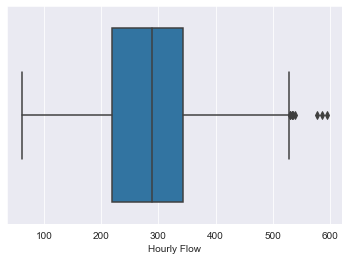

In [16]:
import seaborn as sns
sns.boxplot(x=data_csv['Hourly Flow'])
plt.show()

In [ ]:
data_csv = data_csv[data_csv['Hourly Flow'] <= 520]

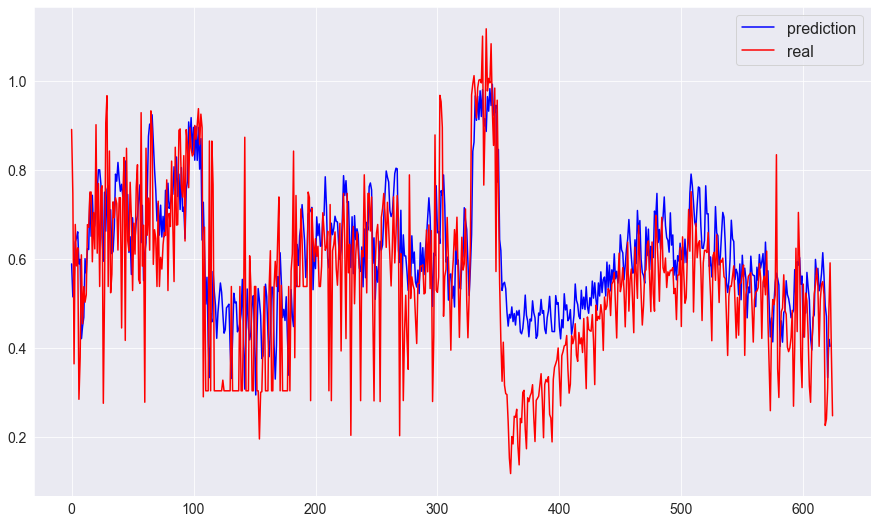

In [14]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import torch 
from torch import nn
from torch.autograd import Variable
 
 
 
data_csv = pd.read_csv('BS1_daily_data_19_20.csv',usecols=[7])
 
# plt.plot(data_csv)
# plt.show()
#数据预处理

data_csv = data_csv.dropna() #去掉na数据
dataset = data_csv.values #字典(Dictionary) values()：返回字典中的所有值
dataset = dataset.astype('float32') # astype(type):实现变量类型转换  
max_value = np.max(dataset)
min_value = np.min(dataset)
scalar = max_value-min_value
dataset = list(map(lambda x: x/scalar, dataset)) #将数据标准化到0~1之间

def create_dataset(dataset,look_back=2):
    dataX, dataY=[], []
    for i in range(len(dataset)-look_back):
        a=dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i+look_back])
    return np.array(dataX), np.array(dataY)
 
data_X, data_Y = create_dataset(dataset)


class lstm_reg(nn.Module):
    def __init__(self,input_size,hidden_size, output_size=1,num_layers=2):
        super(lstm_reg,self).__init__()
 
        self.rnn = nn.LSTM(input_size,hidden_size,num_layers)
        self.reg = nn.Linear(hidden_size,output_size)
 
    def forward(self,x):
        x, _ = self.rnn(x)
        s,b,h = x.shape
        x = x.view(s*b, h)
        x = self.reg(x)
        x = x.view(s,b,-1)
        return x
 
 
net = lstm_reg(2,4)

net.load_state_dict(torch.load('net_params_covid.pkl')) 

data_X = data_X.reshape(-1, 1, 2) #reshape中，-1使元素变为一行，然后输出为1列，每列2个子元素
data_X = torch.from_numpy(data_X) #torch.from_numpy(): numpy中的ndarray转化成pytorch中的tensor（张量）
var_data = Variable(data_X) #转为Variable（变量）
pred_test = net(var_data)  #产生预测结果
pred_test = pred_test.view(-1).data.numpy() #view(-1)输出为一行

fig = plt.figure(figsize=(15, 9))
plt.plot(pred_test, 'b', label='prediction')
plt.plot(dataset, 'red', label='real')
plt.legend(loc='best', fontsize=16) #loc显示图像  'best'表示自适应方式
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()